In [91]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [92]:
from statsmodels.tsa.ar_model import AR,ARResults

In [93]:
len(df)

3434

In [94]:
# Set one year for testing so 48 weeks 
testPeriod = len(df) -365
train = df.iloc[:testPeriod]
test = df.iloc[testPeriod:]

In [95]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [96]:
# try an AR(1) model
model = AR(train['price'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const       9.313031
L1.price    0.999365
dtype: float64


In [97]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

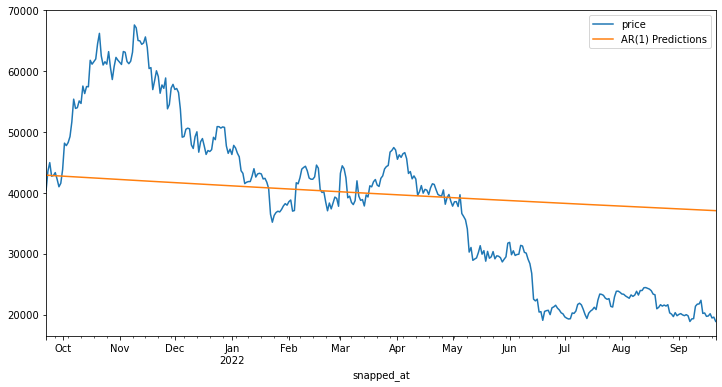

In [98]:
test['price'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

In [101]:
# Recall that our model was already created above based on the training set
# # try an AR(2) model
model5 = AR(train['price'])
AR5fit = model5.fit(maxlag=5,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const       13.667312
L1.price          NaN
L2.price     0.054100
dtype: float64


In [102]:
start=len(train)
end=len(train)+len(test)-1
predictions5 = AR5fit.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')

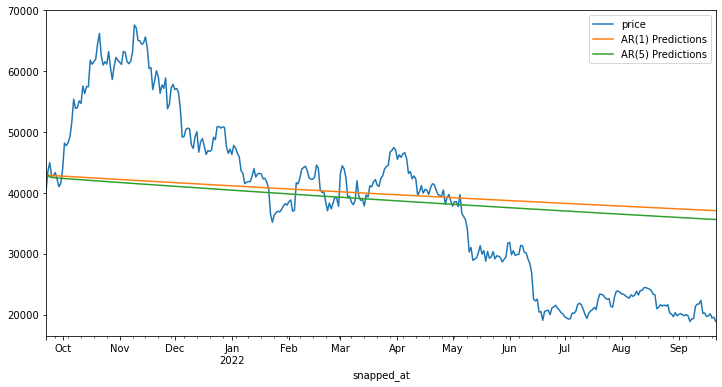

In [103]:
test['price'].plot(legend=True)
predictions1.plot(legend=True)
predictions5.plot(legend=True,figsize=(12,6));

In [104]:
# automatic selection 
modelN = AR(train['price'])
ARfit = modelN.fit( method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 28
Coefficients:
const        10.954136
L1.price      0.951992
L2.price      0.108088
L3.price     -0.000645
L4.price     -0.060797
L5.price     -0.000213
L6.price      0.023645
L7.price     -0.061741
L8.price     -0.023788
L9.price      0.110649
L10.price     0.064974
L11.price    -0.089618
L12.price    -0.106171
L13.price     0.118311
L14.price    -0.072565
L15.price     0.018095
L16.price    -0.006202
L17.price     0.048760
L18.price    -0.030847
L19.price    -0.049465
L20.price     0.140513
L21.price    -0.105635
L22.price     0.001858
L23.price    -0.031191
L24.price     0.120073
L25.price    -0.049434
L26.price     0.029969
L27.price    -0.000393
L28.price    -0.049078
dtype: float64


In [105]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(28) Predictions'

predictions28 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

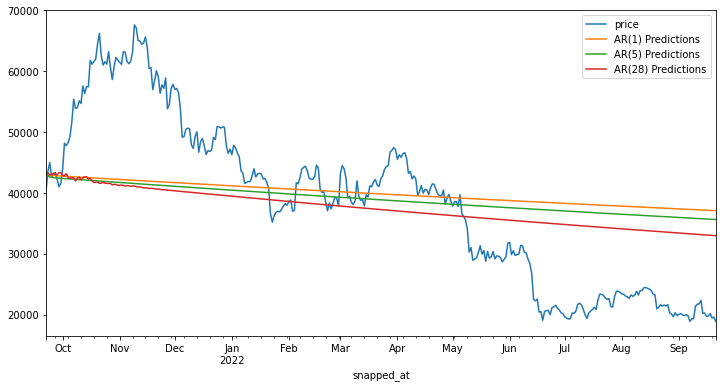

In [106]:
test['price'].plot(legend=True)
predictions1.plot(legend=True)
predictions5.plot(legend=True)
predictions28.plot(legend=True,figsize=(12,6));

In [107]:
predictions28

2021-09-22 00:00:00+00:00    43388.322722
2021-09-23 00:00:00+00:00    43291.486810
2021-09-24 00:00:00+00:00    42979.475746
2021-09-25 00:00:00+00:00    42961.666142
2021-09-26 00:00:00+00:00    43254.285300
                                 ...     
2022-09-17 00:00:00+00:00    33055.106915
2022-09-18 00:00:00+00:00    33033.662862
2022-09-19 00:00:00+00:00    33012.241516
2022-09-20 00:00:00+00:00    32990.842849
2022-09-21 00:00:00+00:00    32969.466833
Freq: D, Name: AR(28) Predictions, Length: 365, dtype: float64

In [108]:
# evaluate the model

In [109]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(5)','AR(28)']
preds = [predictions1, predictions5, predictions28]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['price'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 144990143.8
AR(5) Error: 136412016.6
AR(28) Error: 121855099.2


In [111]:
modls = [AR1fit,AR5fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 12.878
AR(5) AIC: 12.872
AR(28) AIC:  12.83


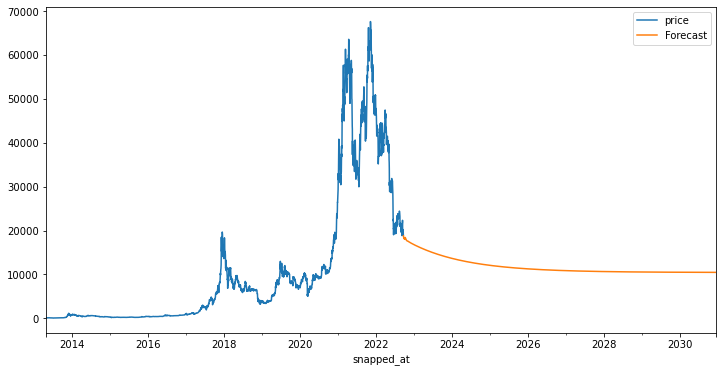

In [114]:
# all 3 performed equally bad!!!!
# Now lets try and forecast basis this

# First, retrain the model on the full dataset
model = AR(df['price'])

# Next, fit the model
ARfit = model.fit(method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+3000, dynamic=False).rename('Forecast')

# Plot the results
df['price'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

In [116]:
# using plotly 
result = df.join(fcast, how='outer')
result[['price','Forecast']].iplot(logy=True)